In [4]:
from lightkurve import KeplerTargetPixelFile

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import SkyCoord

### Load the custom target pixel file

In [6]:
newtpf = KeplerTargetPixelFile('M35_25030.fits', target_id="25030")

### Take a look at one of the frames to find the target star and make a mask for it

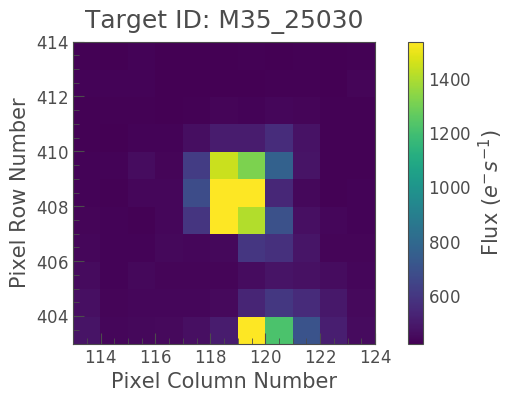

In [7]:
newtpf.plot(frame=0);

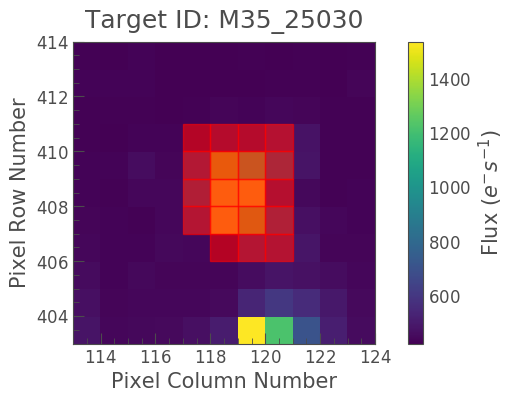

In [8]:
aper = np.zeros(newtpf.shape[1:], dtype=np.int)
aper = newtpf.create_threshold_mask(2)
newtpf.plot(aperture_mask=aper, mask_color='red');

### Make a separate mask to measure the background light

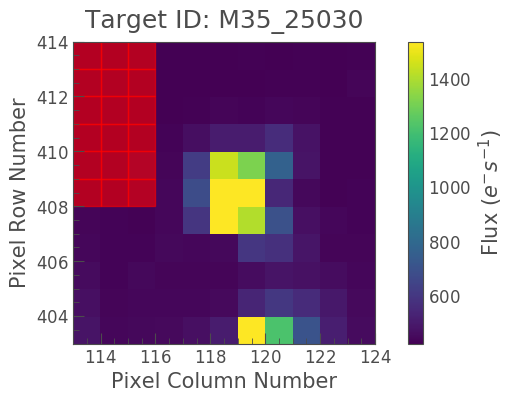

In [9]:
aper2 = np.zeros(newtpf.shape[1:], dtype=np.int)
aper2[-6:,0:3] = 1
newtpf.plot(aperture_mask=aper2, mask_color='red');

### Create light curves of the target and the background

In [10]:
lc = newtpf.to_lightcurve(aperture_mask=aper.astype(bool))

In [11]:
lc2 = newtpf.to_lightcurve(aperture_mask=aper2.astype(bool))

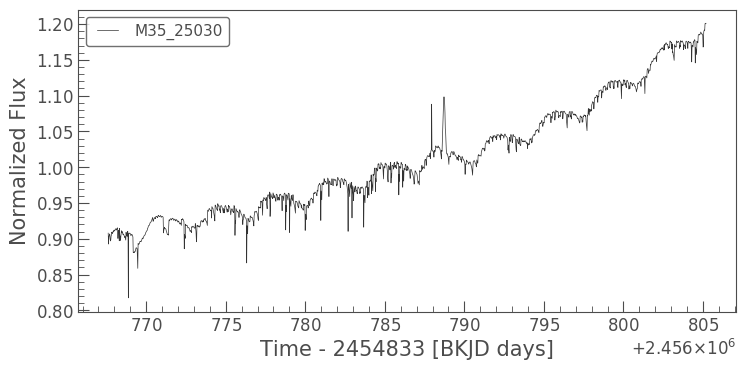

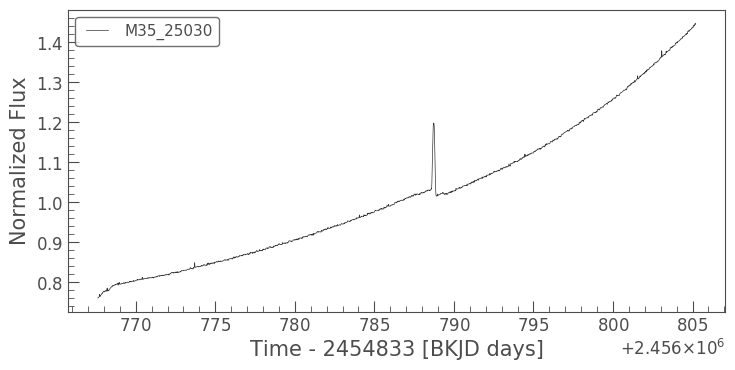

In [12]:
%matplotlib inline
lc.plot();
lc2.plot();

### Remove the background 

In [13]:
lcnew = newtpf.to_lightcurve(aperture_mask=aper.astype(bool))

In [14]:
lcnew.flux = lc.flux - lc2.flux*aper.sum()/aper2.sum()

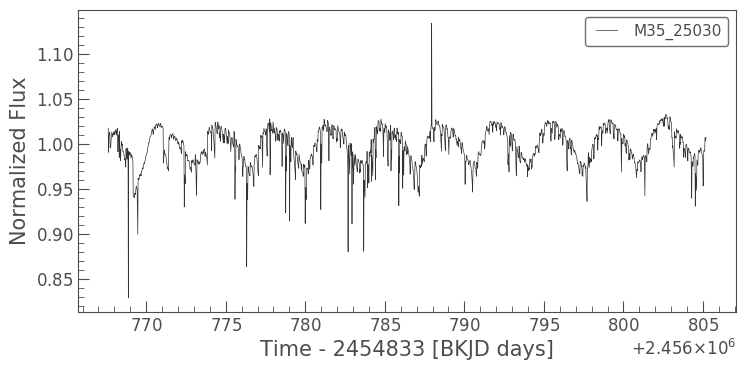

In [15]:
lcnew.plot()

### Perform the self flat fielding method of detrending

In [16]:
m = lcnew.flatten(window_length=31).flux > 0.96
corr = lcnew[m].to_corrector('sff')
corr_lc = corr.correct(centroid_col=newtpf.pos_corr1[m], centroid_row=newtpf.pos_corr2[m], restore_trend=True, windows=10, bins=10, niters=5,  sigma_2=3)

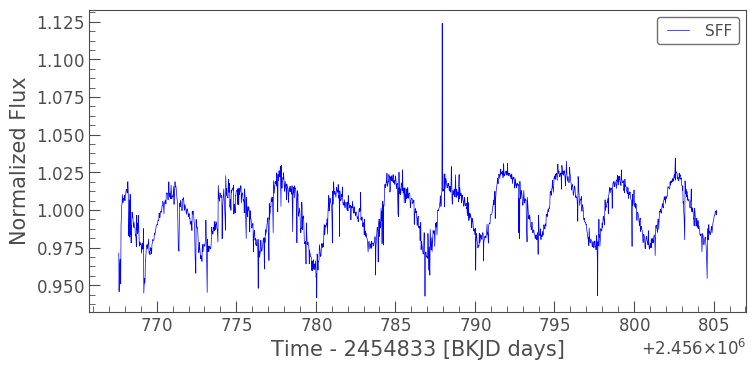

In [17]:
ax = (corr_lc).plot(c='b', label='SFF')

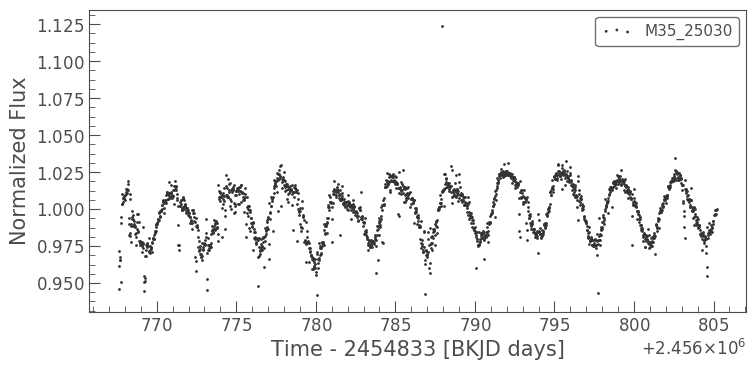

In [18]:
corr_lc.scatter();

### Prepare the light curve to also input to the k2sc detrender

In [21]:
lcnew.primary_header = newtpf.hdu[0].header
lcnew.data_header = newtpf.hdu[1].header
lcnew.pos_corr1 = (newtpf.hdu[1].data['POS_CORR1'])[newtpf.quality_mask]
lcnew.pos_corr2 = (newtpf.hdu[1].data['POS_CORR2'])[newtpf.quality_mask]

In [22]:
from k2sc.standalone import k2sc_lc

In [23]:
lcnew.__class__ = k2sc_lc

In [24]:
lcnew.k2sc(splits=[1932])

Using split values [1932] given from the command line
Starting initial outlier detection
  Flagged 5 ( 0.3%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    3.52 (fap 9.6362e-313 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -2987.210308338781
  DE iteration %3i -ln(L) %4.1f 1 -2987.210308338781
  DE iteration %3i -ln(L) %4.1f 2 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 3 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 4 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 5 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 6 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 7 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 8 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 9 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 10 -3005.069740764762
  DE iteration %3i -ln(L) %4.1f 11 -3026.110276113991
  DE iteration %3i -ln(L) %4.1f 

### Compare the different detrending results

Text(0.5,1.01,'M35 25030')

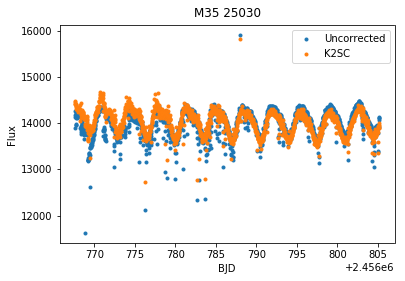

In [25]:
plt.plot(lcnew.time,lcnew.flux,'.',label="Uncorrected")
plt.plot(lcnew.time,lcnew.corr_flux,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('M35 25030',y=1.01)

(0.85, 1.1)

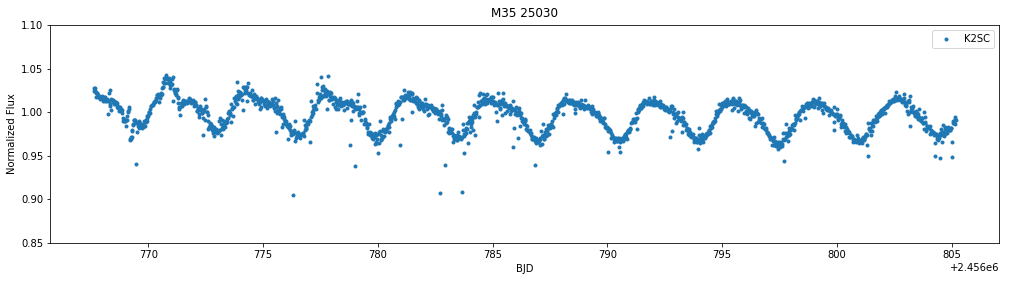

In [26]:
plt.figure(figsize=[17, 4])
plt.plot(lcnew.time,lcnew.corr_flux/np.median(lcnew.corr_flux),'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Normalized Flux')
plt.title('M35 25030',y=1.01)
plt.ylim(0.85,1.1)

(0.85, 1.1)

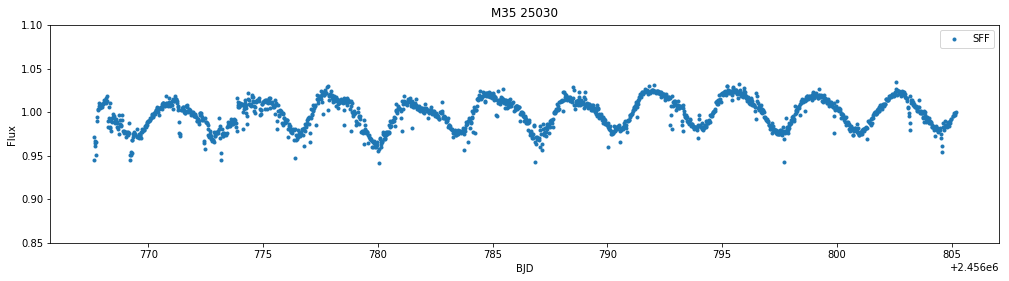

In [28]:
plt.figure(figsize=[17, 4])
plt.plot(corr_lc.time,corr_lc.flux/np.median(corr_lc.flux),'.',label="SFF")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('M35 25030',y=1.01)
plt.ylim(0.85,1.1)